In [1]:
import pandas as pd
event_data = pd.read_csv('event_data_train.csv')
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')
event_data['day'] = event_data.date.dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


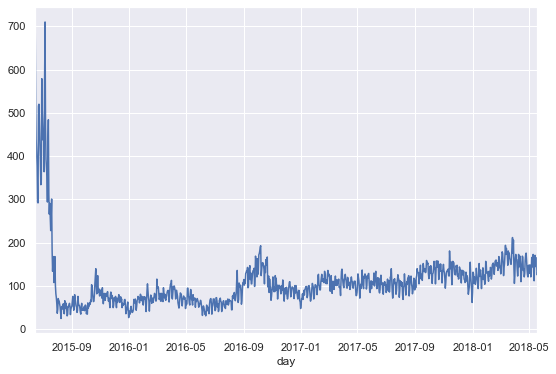

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize': (9,6)})
event_data.groupby('day').user_id.nunique().plot()

In [3]:
user_steps = event_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [5]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

In [6]:
import numpy as np
gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

In [7]:
# event_data[['user_id', 'action']].pivot_table(index='user_id', values='action', aggfunc='count').sort_values(['action'], ascending=False).head()
submissions_data[['user_id', 'submission_status']].pivot_table(index='user_id', values='submission_status', aggfunc='count').sort_values(['submission_status'], ascending=False).head()

,submission_status
user_id,
12265,1051
3643,948
1046,934
14454,920
643,888


In [8]:
users_data = event_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'})
now_timestamp = 1526772811
dropout_timestamp = 30 * 24 * 60 * 60
users_data['is_gone'] = (now_timestamp - users_data.timestamp) > dropout_timestamp
users_data

,user_id,timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [9]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)
users_data.head(20)

,user_id,timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
5,8,1481466913,True,9.0,21.0
6,9,1484999497,True,0.0,0.0
7,11,1526140625,False,0.0,0.0
8,14,1436368676,True,0.0,1.0
9,16,1513162585,True,0.0,0.0


In [10]:
users_data = users_data.merge(user_steps, on='user_id', how='outer')
users_data.head()

,user_id,timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [11]:
user_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(user_days, on='user_id', how='outer')
users_data.head()

,user_id,timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [12]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
